In [20]:
%load_ext blackcellmagic

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


In [21]:
import datetime
import spiceypy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt


spiceypy.furnsh("meta.txt")

DATETIME_UTC = datetime.datetime.now().strftime("%Y-%m-%dT%H:%M:%S")
DATETIME_ET = spiceypy.utc2et(DATETIME_UTC)

In [22]:
solar_system_df = pd.DataFrame()

solar_system_df.loc[:, "ET"] = [DATETIME_ET]
solar_system_df.loc[:, "UTC"] = [DATETIME_UTC]

SOLAR_SYSTEM_DICT = {"SUN": 10, "MERCURY": 199, "VENUS": 299, "MARS": 4}

In [23]:
for body_name in SOLAR_SYSTEM_DICT:

    solar_system_df.loc[:, f"dir_{body_name}_wrt_earth_ecl"] = solar_system_df[
        "ET"
    ].apply(
        lambda x: spiceypy.spkezp(
            targ=SOLAR_SYSTEM_DICT[body_name],
            et=x,
            ref="ECLIPJ2000",
            abcorr="LT+S",
            obs=399,
        )[0]
    )

    solar_system_df.loc[:, f"{body_name}_long_rad_ecl"] = solar_system_df[
        f"dir_{body_name}_wrt_earth_ecl"
    ].apply(lambda x: spiceypy.recrad(x)[1])

    solar_system_df.loc[:, f"{body_name}_lat_rad_ecl"] = solar_system_df[
        f"dir_{body_name}_wrt_earth_ecl"
    ].apply(lambda x: spiceypy.recrad(x)[2])

solar_system_df

,ET,UTC,dir_SUN_wrt_earth_ecl,SUN_long_rad_ecl,SUN_lat_rad_ecl,dir_MERCURY_wrt_earth_ecl,MERCURY_long_rad_ecl,MERCURY_lat_rad_ecl,dir_VENUS_wrt_earth_ecl,VENUS_long_rad_ecl,VENUS_lat_rad_ecl,dir_MARS_wrt_earth_ecl,MARS_long_rad_ecl,MARS_lat_rad_ecl
0,6.975158e+08,2022-02-07T14:21:38,"[110466478.82812701, -97813172.39325266, 4102....",5.558464,0.000028,"[51367519.35248031, -111402211.42014648, 43138...",5.144435,0.035151,"[12057295.98638176, -54893223.3566303, 6271491...",4.928605,0.111129,"[54985087.217584364, -313324981.4828227, -3151...",4.886109,-0.009908


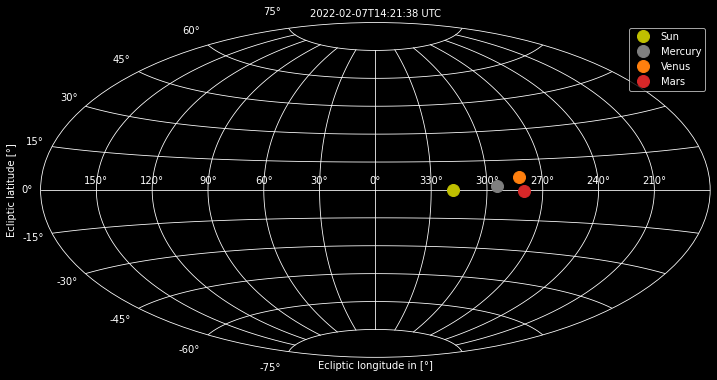

In [24]:
for body_name in SOLAR_SYSTEM_DICT:
    solar_system_df.loc[:, f"{body_name}_long_rad4plot_ecl"] = solar_system_df[
        f"{body_name}_long_rad_ecl"
    ].apply(lambda x: -1 * ((x % np.pi) - np.pi) if x > np.pi else -1 * x)


plt.style.use("dark_background")
plt.figure(figsize=(12, 8))
plt.subplot(projection="aitoff")
plt.title(f"{DATETIME_UTC} UTC", fontsize=10)

BODY_COLOR_ARRAY = ["y", "tab:gray", "tab:orange", "tab:red"]

for body_name, body_color in zip(SOLAR_SYSTEM_DICT, BODY_COLOR_ARRAY):

    plt.plot(
        solar_system_df[f"{body_name}_long_rad4plot_ecl"],
        solar_system_df[f"{body_name}_lat_rad_ecl"],
        color=body_color,
        marker="o",
        linestyle="None",
        markersize=12,
        label=body_name.capitalize(),
    )

plt.xticks(
    ticks=np.radians([-150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150]),
    labels=[
        "150°",
        "120°",
        "90°",
        "60°",
        "30°",
        "0°",
        "330°",
        "300°",
        "270°",
        "240°",
        "210°",
    ],
)
plt.xlabel("Ecliptic longitude in [°]")
plt.ylabel("Ecliptic latitude [°]")
plt.legend()
plt.grid(True)
plt.savefig("eclipj2000_sky_map.png", dpi=300)

In [25]:
for body_name in SOLAR_SYSTEM_DICT:

    solar_system_df.loc[:, f"dir_{body_name}_wrt_earth_equ"] = solar_system_df[
        "ET"
    ].apply(
        lambda x: spiceypy.spkezp(
            targ=SOLAR_SYSTEM_DICT[body_name], et=x, ref="J2000", abcorr="LT+S", obs=399
        )[0]
    )

    solar_system_df.loc[:, f"{body_name}_long_rad_equ"] = solar_system_df[
        f"dir_{body_name}_wrt_earth_equ"
    ].apply(lambda x: spiceypy.recrad(x)[1])
    solar_system_df.loc[:, f"{body_name}_lat_rad_equ"] = solar_system_df[
        f"dir_{body_name}_wrt_earth_equ"
    ].apply(lambda x: spiceypy.recrad(x)[2])

    solar_system_df.loc[:, f"{body_name}_long_rad4plot_equ"] = solar_system_df[
        f"{body_name}_long_rad_equ"
    ].apply(lambda x: -1 * ((x % np.pi) - np.pi) if x > np.pi else -1 * x)

In [26]:
eclip_plane_df = pd.DataFrame()

eclip_plane_df.loc[:, "ECLIPJ2000_long_rad"] = np.linspace(0, 2 * np.pi, 100)
eclip_plane_df.loc[:, "ECLIPJ2000_lat_rad"] = np.pi / 2.0

eclip_plane_df.loc[:, "ECLIPJ2000_direction"] = eclip_plane_df.apply(
    lambda x: spiceypy.sphrec(
        r=1, colat=x["ECLIPJ2000_lat_rad"], lon=x["ECLIPJ2000_long_rad"]
    ),
    axis=1,
)

In [27]:
ECL2EQU_MAT = spiceypy.pxform(fromstr="ECLIPJ2000", tostr="J2000", et=DATETIME_ET)

eclip_plane_df.loc[:, "j2000_direction"] = eclip_plane_df["ECLIPJ2000_direction"].apply(
    lambda x: ECL2EQU_MAT.dot(x)
)

eclip_plane_df.loc[:, "j2000_long_rad"] = eclip_plane_df["j2000_direction"].apply(
    lambda x: spiceypy.recrad(x)[1]
)

eclip_plane_df.loc[:, "j2000_long_rad4plot"] = eclip_plane_df["j2000_long_rad"].apply(
    lambda x: -1 * ((x % np.pi) - np.pi) if x > np.pi else -1 * x
)

eclip_plane_df.loc[:, "j2000_lat_rad"] = eclip_plane_df["j2000_direction"].apply(
    lambda x: spiceypy.recrad(x)[2]
)

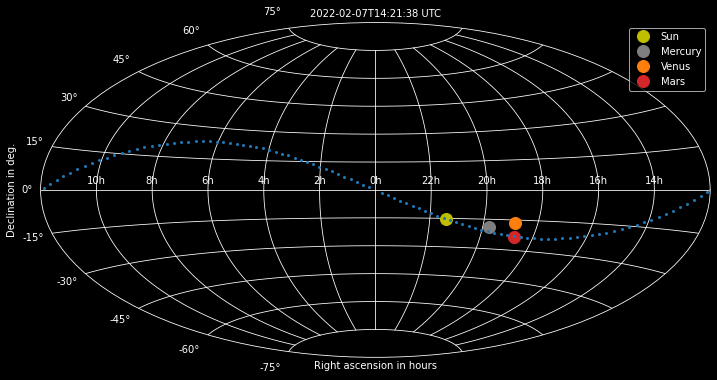

In [28]:
plt.style.use("dark_background")
plt.figure(figsize=(12, 8))
plt.subplot(projection="aitoff")
plt.title(f"{DATETIME_UTC} UTC", fontsize=10)

for body_name, body_color in zip(SOLAR_SYSTEM_DICT, BODY_COLOR_ARRAY):

    plt.plot(
        solar_system_df[f"{body_name}_long_rad4plot_equ"],
        solar_system_df[f"{body_name}_lat_rad_equ"],
        color=body_color,
        marker="o",
        linestyle="None",
        markersize=12,
        label=body_name.capitalize(),
    )

# Plot the Ecliptic plane as a blue dotted line
plt.plot(
    eclip_plane_df["j2000_long_rad4plot"],
    eclip_plane_df["j2000_lat_rad"],
    color="tab:blue",
    linestyle="None",
    marker="o",
    markersize=2,
)

# Convert the longitude values finally in right ascension hours
plt.xticks(
    ticks=np.radians([-150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150]),
    labels=["10h", "8h", "6h", "4h", "2h", "0h", "22h", "20h", "18h", "16h", "14h"],
)

# Plot the labels
plt.xlabel("Right ascension in hours")
plt.ylabel("Declination in deg.")

# Create a legend and grid
plt.legend()
plt.grid(True)

# Save the figure
plt.savefig("j2000_sky_map.png", dpi=300)